In [1]:
import os
import nibabel as nib
import pandas as pd
import numpy as np
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from tqdm import tqdm  # progress bar

# Set up
base_path = "."
subject = "sub-005"
n_runs = 6
t_r = 2.0  # repetition time (2 seconds)

# Load atlas & prepare masker
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, resolution_mm=2)
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True, t_r=t_r)

# Prepare result lists
X_all = []
y_all = []

# Loop through all 6 runs
for run in tqdm(range(1, n_runs + 1)):
    run_str = f"run-0{run}"
    bold_file = f"{base_path}/{subject}_task-Test_{run_str}_bold.nii"
    events_file = f"{base_path}/{subject}_task-Test_{run_str}_events.tsv"

    # Check if both files exist
    
    print(f"Looking for: {bold_file}")
    print(f"Looking for: {events_file}")


    if not os.path.exists(bold_file) or not os.path.exists(events_file):
        print(f"Missing: {run_str}")
        continue

    # Load data
    func_img = nib.load(bold_file)
    events = pd.read_csv(events_file, sep="\t")
    roi_ts = masker.fit_transform(func_img)  # shape: [timepoints, 100]

    # Segment into trials
    for _, row in events.iterrows():
        onset = row['onset']
        duration = row['duration']
        genre = row['genre'].strip("'").strip('"')

        start_vol = int(onset / t_r)
        end_vol = int((onset + duration) / t_r)
        trial_ts = roi_ts[start_vol:end_vol, :]

        if trial_ts.shape[0] < 2:
            continue  # skip too-short segments

        # Compute connectivity
        conn_matrix = np.corrcoef(trial_ts.T)

        # Flatten upper triangle
        try:
            flat = conn_matrix[np.triu_indices_from(conn_matrix, k=1)]
            if not np.isnan(flat).any() and len(flat) == 4950:
                X_all.append(flat)
                y_all.append(genre)
        except:
            print(f"⚠️ Skipped a trial due to shape or NaN issue.")


# Convert to numpy arrays
X_all = np.array(X_all)
y_all = np.array(y_all)

  0%|                                                     | 0/6 [00:00<?, ?it/s]

Looking for: ./sub-005_task-Test_run-01_bold.nii
Looking for: ./sub-005_task-Test_run-01_events.tsv


 17%|███████▌                                     | 1/6 [00:20<01:40, 20.02s/it]

Looking for: ./sub-005_task-Test_run-02_bold.nii
Looking for: ./sub-005_task-Test_run-02_events.tsv


 33%|███████████████                              | 2/6 [00:39<01:18, 19.71s/it]

Looking for: ./sub-005_task-Test_run-03_bold.nii
Looking for: ./sub-005_task-Test_run-03_events.tsv


/Users/chenxuan/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_labels_masker.py:805: UserWarning: After resampling the label image to the data image, the following labels were removed: {4.0, 5.0, 54.0}. Label image only contains 98 labels (including background).
  warnings.warn(
 50%|██████████████████████▌                      | 3/6 [00:59<00:59, 19.69s/it]

Looking for: ./sub-005_task-Test_run-04_bold.nii
Looking for: ./sub-005_task-Test_run-04_events.tsv


 67%|██████████████████████████████               | 4/6 [01:18<00:38, 19.47s/it]

Looking for: ./sub-005_task-Test_run-05_bold.nii
Looking for: ./sub-005_task-Test_run-05_events.tsv


 83%|█████████████████████████████████████▌       | 5/6 [01:37<00:19, 19.44s/it]

Looking for: ./sub-005_task-Test_run-06_bold.nii
Looking for: ./sub-005_task-Test_run-06_events.tsv


100%|█████████████████████████████████████████████| 6/6 [01:56<00:00, 19.48s/it]


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# Apply PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

print("New shape after PCA:", X_pca.shape)

New shape after PCA: (164, 50)


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred = cross_val_predict(clf, X_pca, y_all, cv=3)

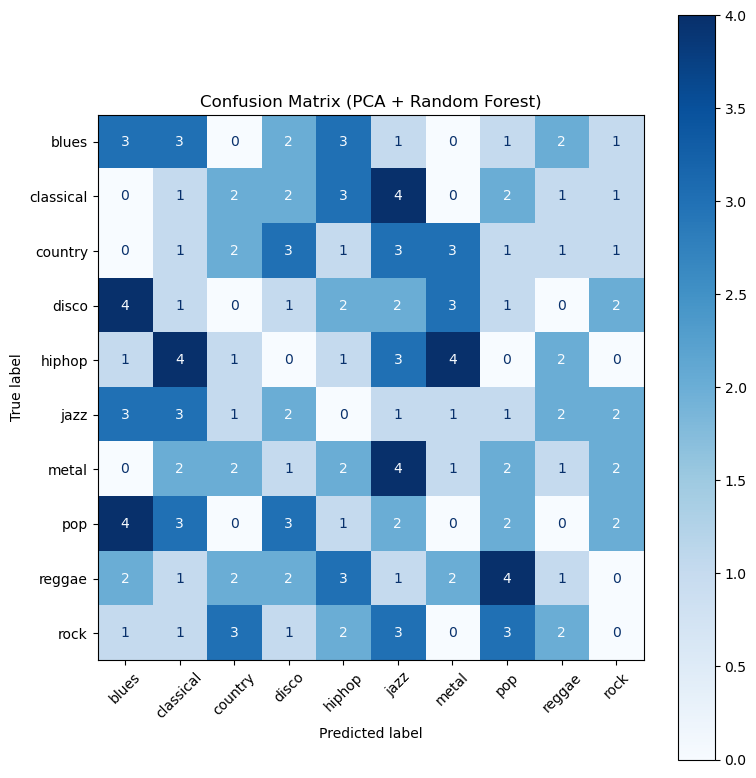

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Optional: sort genres alphabetically for display
labels = sorted(np.unique(y_all))

cm = confusion_matrix(y_all, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (PCA + Random Forest)")
plt.tight_layout()
plt.show()